In [50]:
from datetime import datetime
import pandas as pd
from geopy import distance
import numpy as np

import pymongo
from pymongo import MongoClient

from sklearn.cluster import DBSCAN

from sklearn.metrics.pairwise import pairwise_distances

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [13]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']
trip_coll = db['trips']
edge_coll = db['edges_standardized']

In [27]:
wknd_filter = {
    "weekend": 1,
}

projection = {
    "_id": 0,
    "trip_duration": 1,
    "minute_since_midnight": 1
}

weekends = list(trip_coll.find(wknd_filter, projection))
wknd_lst = [item['trip_duration'] for item in weekends]
wknd_msm_lst = [item['minute_since_midnight'] for item in weekends]

In [30]:
wkdy_filter = {
    "weekend": 0,
}

projection = {
    "_id": 0,
    "trip_duration": 1,
    "minute_since_midnight": 1
}

weekdays = list(trip_coll.find(wkdy_filter, projection))
wkdy_lst = [item['trip_duration'] for item in weekdays]
wkdy_msm_lst = [item['minute_since_midnight'] for item in weekdays]

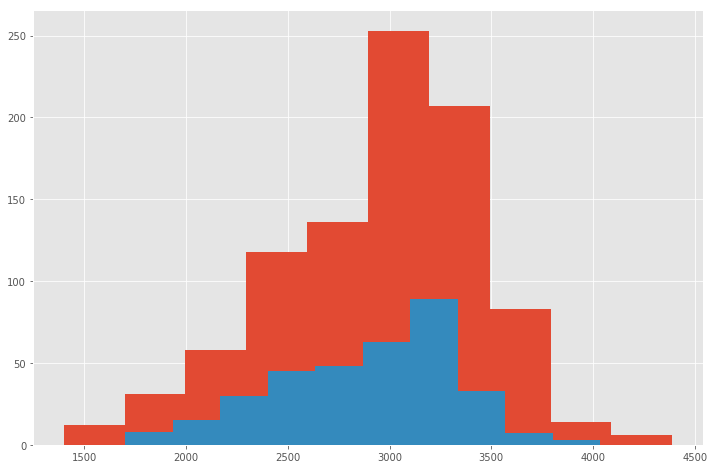

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(wkdy_lst)
ax.hist(wknd_lst);

Okay, so their distributions are similar...

Let's compare scatter plots?

The weekend:

Text(0,0.5,'Trip duration')

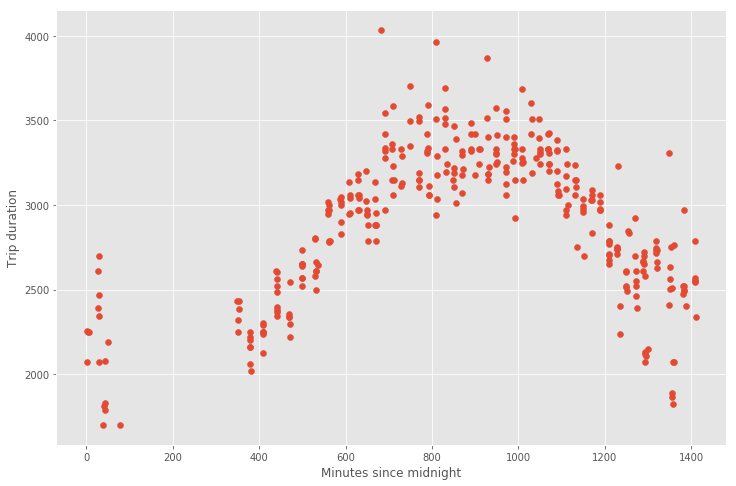

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(wknd_msm_lst, wknd_lst)
ax.set_xlabel("Minutes since midnight")
ax.set_ylabel("Trip duration")

Weekdays:

Text(0,0.5,'Trip duration')

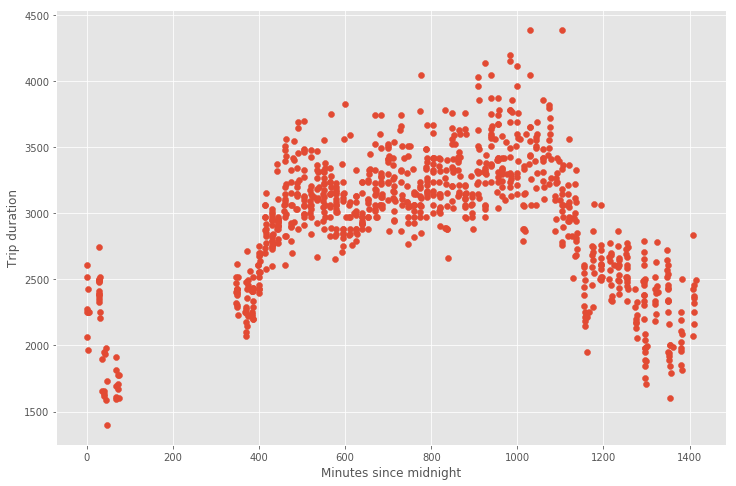

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(wkdy_msm_lst, wkdy_lst)
ax.set_xlabel("Minutes since midnight")
ax.set_ylabel("Trip duration")

Okay, let's do some DBSCANNING

In [132]:
wknd_feature_lst = [[item['minute_since_midnight'], item['trip_duration']] for item in weekends]
wknd_features = np.array(wknd_feature_lst)

First, let's get average euclidean distance

In [133]:
dists = pairwise_distances(wknd_features)
dist_mean = np.mean(dists)
dist_std = np.std(dists)
print (dist_mean, ", ", dist_std)

687.4662485071888 ,  407.4904007460517


In [134]:
db = DBSCAN(eps=100, min_samples=15).fit(wknd_features)

In [135]:
# Let's make an array, the same size as our labels
# Will be True if the index is a core point, otherwise false 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

In [136]:
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

4

In [137]:
# Lets get colors for each label
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

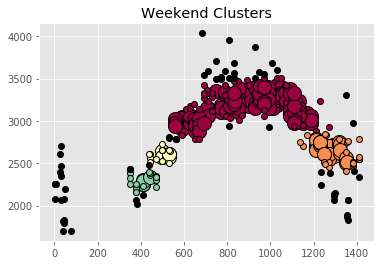

In [138]:
# For each label and color

for k, col in zip(unique_labels, colors):
    
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    # Get the indices of all rows with this label
    class_member_mask = (labels == k)

    # Get class members who are cores
    xy = wknd_features[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # Get class members who aren't cores
    xy = wknd_features[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Weekend Clusters')
plt.show()

What about K Means?

In [158]:
x = np.linspace(-51,50,100)
y = -(x**2)

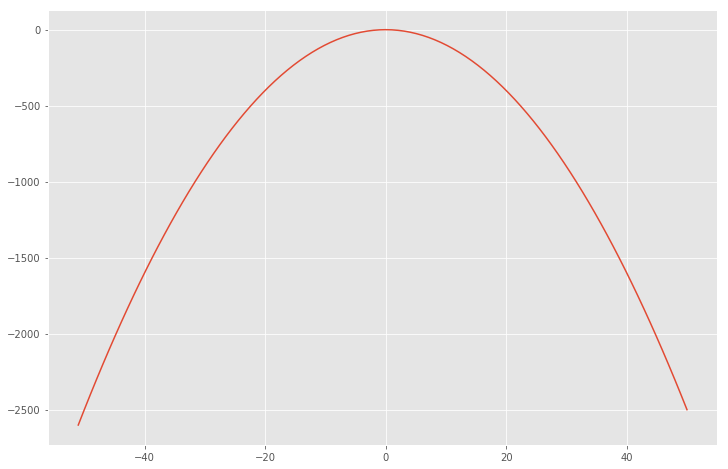

In [159]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y)